---
**Dataset:** *Coral reef global bleaching*


**Objective:** *Predict reef bleaching*

**Author:** *Danylo Zemskyi, Omari March*

**Date:** *15/12/2025*

---

## 1. Introduction

### 1.1 Problem Statement

* Description of the task:Bleaching prediction for Coral Reef Global Bleaching dataset.
* Target variable: This problem is about predicting how much coral bleaching occurs (measured as Percent Bleaching) based on environmental and physical factors like water depth, temperature, distance from shore, exposure, turbidity, and cyclone frequency (Regression problem).
* Topic relevance: Coral reefs play a vital role in marine ecosystem health. Coral reefs are able to support diverse ecosystems, filter the water, and create oxygen when they have clean, clear, and cool water to support them. Also, they protect shorelines by reducing the impact from waves, storms, and floods. This helps prevent loss of life, property damage, and erosion. When reefs are damaged or destroyed, coastal communities can suffer increased damage from severe storms, and even normal wave action. Bleached corals continue to live, but they are more vulnerable to disease and starvation.

### 1.2 Dataset Overview

* Source of the dataset: https://www.kaggle.com/datasets/mehrdat/coral-reef-global-bleaching
* Number of samples and features: The dataset consists of 2 csv files, which have 18 and 62 Features, and 41361 rows each. Csv file with 62 features provides a lot of redundant metrics that can be derived with formulas. Both files can be merged by Sample_ID column
* Feature types (numerical, categorical, target)


## 2. Experimental Setup

### 2.1 Libraries

Used libs
numpy
pandas

matplotlib
seaborn
os

sklearn
statsmodels
scipy

xgboost
tensorflow.keras

### 2.2 Evaluation Metrics

* Metrics used: R2 and MAE
* Justification: MAE is preferred in tasks involving skewed or outlier-prone data because it provides a robust, scale-consistent measure of average model error without disproportionately penalizing large deviations.
	As the baseline model mean predictor was chosen, which can give a sense what is the minimal mean absolute error model has to archive to be better than a simple mean model (MAEbaseline = 11.29).
	R2 provides an interpretable measure of overall model fit and how well the model captures data patterns relative to a naive mean-based predictor, which is picked as baseline performance.

### 2.3 Dataset split

* Split method used: train-test split(TTS)
* TTS chosen over k-fold cross-validation as the dataset is sufficiently large to minimize overfitting risks associated with TTS, while significantly reducing computational cost by requiring only a single model training instead of multiple iterations.




In [92]:
from keras.src.metrics.correlation_metrics import pearson_correlation
from scipy.stats import spearmanr
from tensorflow.python.ops.metrics_impl import root_mean_squared_error

"""Data manipulations libs"""
import numpy as np
import pandas as pd

"""Plotting libs"""
import matplotlib.pyplot as plt
import seaborn as sns
import os

"""Models evaluations imports"""
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

"""Data preprocessing imports"""
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew, boxcox


"""Dataset stats imports"""
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor

"""Models that were used imports"""
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, Dropout, ReLU, Add
)
from tensorflow.keras.callbacks import EarlyStopping

## 3. Baseline Model


### 3.1 Baseline Definition

Since this the task involves regression for Percent_Bleaching prediction, the baseline performance can be assessed using simple models such as the mean predictor or median predictor, which always predict the average or median bleaching percentage across the dataset. That will provide us with a reference level of performance to compare more complex models against.

### 3.2 Baseline Results

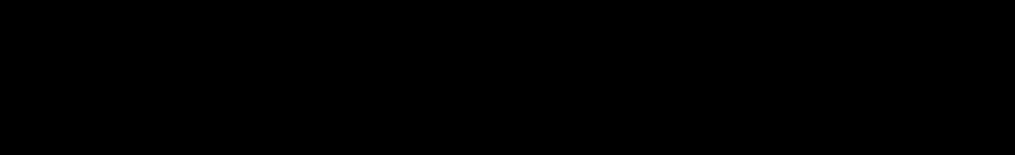

In [102]:
import pandas as pd
import os

path = "./coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df = pd.read_csv(filename_read)

df  = df.drop(columns=['Sample_ID', 'Percent_Cover', 'Date_Year']) #Percent_Cover has 30% of its row NA, so it significantly cuts dataset
df.dropna(inplace=True)

df.info()
print(df)

<class 'pandas.core.frame.DataFrame'>
Index: 32714 entries, 0 to 35044
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cyclone_Frequency    32714 non-null  float64
 1   Depth_m              32714 non-null  float64
 2   ClimSST              32714 non-null  float64
 3   Ocean_Name           32714 non-null  object 
 4   Country_Name         32714 non-null  object 
 5   Distance_to_Shore    32714 non-null  float64
 6   Exposure             32714 non-null  object 
 7   Turbidity            32714 non-null  float64
 8   Bleaching_Level      32714 non-null  object 
 9   Temperature_Maximum  32714 non-null  float64
 10  SSTA                 32714 non-null  float64
 11  TSA                  32714 non-null  float64
 12  Percent_Bleaching    32714 non-null  float64
 13  Temperature_Mean     32714 non-null  float64
 14  Realm_Name           32714 non-null  object 
dtypes: float64(10), object(5)
memory usage: 4

In [79]:
# Target value
y = df['Percent_Bleaching'].to_list()

# Mean prediction
y_median = np.median(y)
y_mean = np.mean(y)

y_pred_median = np.full(len(y), y_median)
y_pred_mean = np.full(len(y), y_mean)

# Metrics Median
mae_median = mean_absolute_error(y, y_pred_median)
rmse_median = root_mean_squared_error(y, y_pred_median)
r2_median = r2_score(y, y_pred_median)

print("Median Baseline Results:")
print(f"MAE: {mae_median:.4f}")
print(f"RMSE: {rmse_median:.4f}")
print(f"R: {r2_median:.4f}")

# Metrics Mean
mae_mean = mean_absolute_error(y, y_pred_mean)
rmse_mean = root_mean_squared_error(y, y_pred_mean)
r2_mean = r2_score(y, y_pred_mean)

print("\nMean Baseline Results:")
print(f"MAE: {mae_mean:.4f}")
print(f"RMSE: {rmse_mean:.4f}")
print(f"R: {r2_mean:.4f}")



Median Baseline Results:
MAE: 8.0678
RMSE: 19.8756
R: -0.1973

Mean Baseline Results:
MAE: 11.2953
RMSE: 18.1646
R: 0.0000


In [ ]:
cat_cols = ['Exposure', 'Bleaching_Level', 'Ocean_Name', 'Country_Name', 'Realm_Name']
num_cols = [col for col in df.columns if col not in cat_cols]

target_value_col = "Percent_Bleaching"

## 4. Exploratory Data Analysis (EDA)

### 4.1 Target Distribution

Histogram shows that target value has a lot of outliers and extremely skewed around 0%, which implies that Percent_Bleaching values has to be scaled to mitigate impact of imbalance distribution and normalized. Such categorical data as Ocean_Name, Country_Name, Exposure, and Realm_Name has to be encoded with OneHotEncoder to make it feedable to the models.

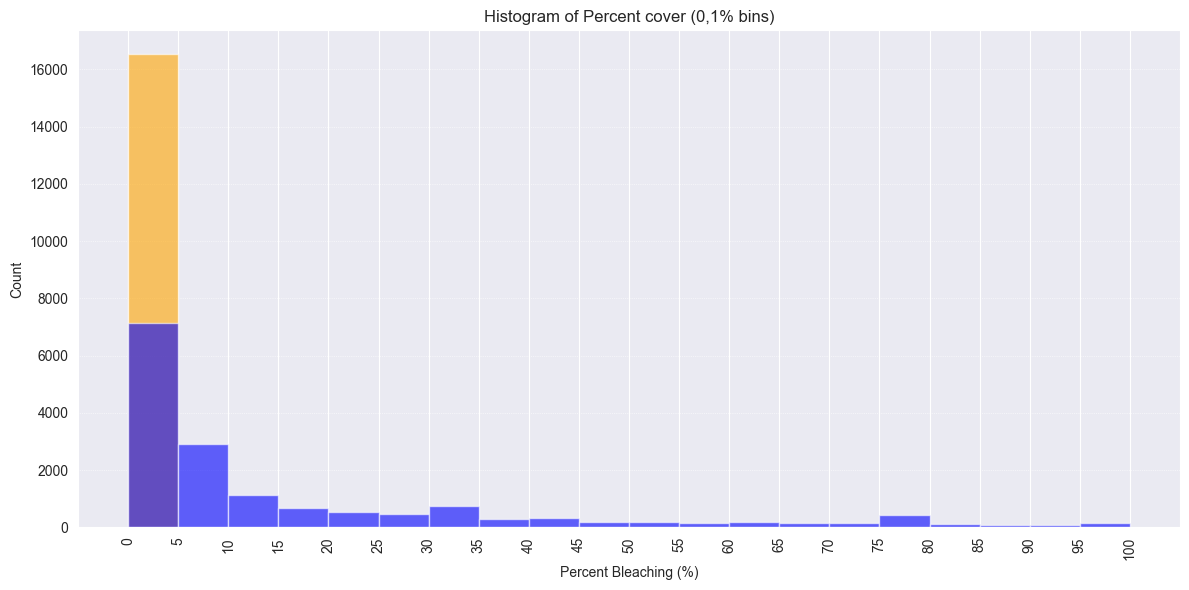

In [110]:

high_bleaching = df[target_value_col] > 0  # 50% threshold
low_bleaching = df[target_value_col] <= 0

bins = np.arange(0, 105, 5)  # from 0 to 100 in steps of 0.5
labels = [f"{b}–{b+5}%" for b in bins[:-1]]



plt.figure(figsize=(12, 6))
plt.hist(
    df.loc[low_bleaching, target_value_col],
    bins=bins,
    color="orange",
    alpha=0.6,
    edgecolor=None,
    label="Low / Not Bleaching (=0%)"
)
plt.hist(
    df.loc[high_bleaching, target_value_col],
    bins=bins,
    color="blue",
    alpha=0.6,
    edgecolor=None,
    label="Bleaching (>0%)"
)
plt.xticks(bins)
plt.xlabel("Percent Bleaching (%)")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Histogram of Percent cover (0,1% bins)")
plt.grid(axis="y", linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()



### 4.2 Feature Distribution and Skewness

The majority of numerical features in the dataset exhibit pronounced skewness, with several key variables showing strong right-skew (e.g., Distance_to_Shore, Turbidity, Percent_Bleaching) and others displaying left-skewed distributions (e.g., ClimSST, Temperature_Mean, TSA), indicating non-normal feature distributions and further motivating the use of transformation and non-linear modeling approaches.


In [109]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
skewness_results = {}

for col in numeric_cols:
    clean_data = df[col].dropna()
    if len(clean_data) > 0:
        skew_val = skew(clean_data)
        skewness_results[col] = {
            'skewness': skew_val,
            'skew_type': 'Right (Positive)' if skew_val > 0.5 else 'Left (Negative)' if skew_val < -0.5 else 'Approximately Symmetric',

        }

skewness_df = pd.DataFrame(skewness_results).T
skewness_df = skewness_df.sort_values('skewness', key=abs, ascending=False)
skewness_df[:-1]

,skewness,skew_type
Distance_to_Shore,9.390477,Right (Positive)
Turbidity,3.848336,Right (Positive)
Percent_Bleaching,2.969849,Right (Positive)
ClimSST,-1.640544,Left (Negative)
Temperature_Mean,-1.320474,Left (Negative)
Depth_m,1.272371,Right (Positive)
TSA,-1.013456,Left (Negative)
Temperature_Maximum,0.930379,Right (Positive)
Cyclone_Frequency,0.891588,Right (Positive)


### 4.3 Feature Relationships

The Pearson correlation matrix shows generally weak linear relationships among the environmental variables and between predictors and the target variable (Percent_Bleaching). Most correlation coefficients are close to zero, indicating limited linear dependence.

<Axes: >

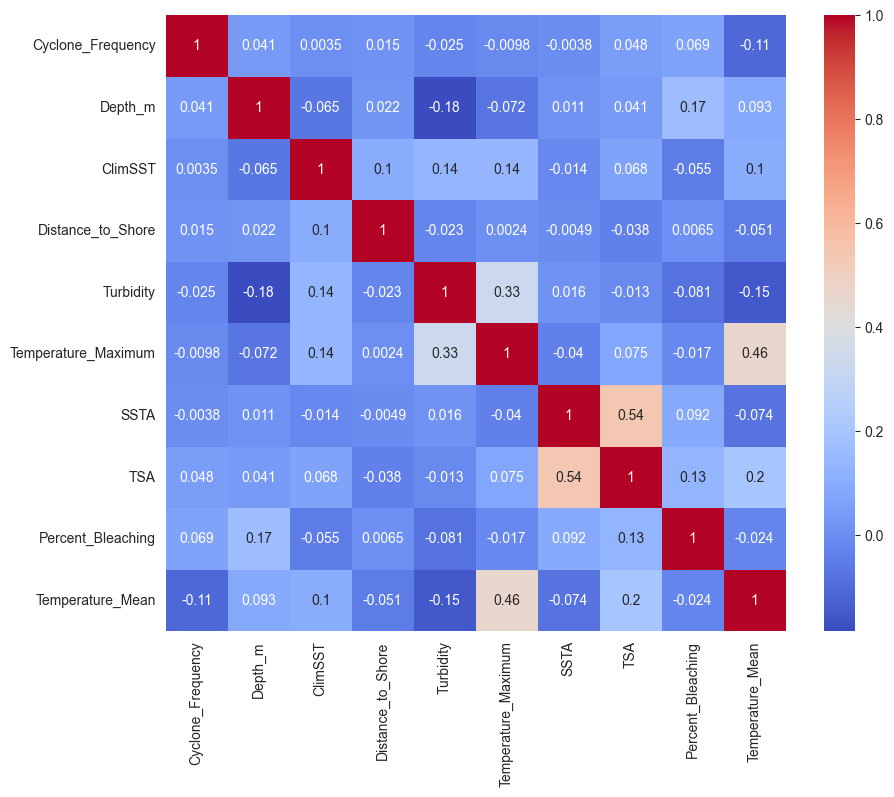

In [83]:

df_numeric = df[num_cols]

pearson_corr_matrix = df_numeric.corr(method="pearson")

features = pearson_corr_matrix.index

plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr_matrix, annot=True, cmap="coolwarm")

The Spearman correlation matrix reveals stronger monotonic relationships than those observed with Pearson correlation, indicating that several variables are related in a non-linear but monotonic manner.

<Axes: >

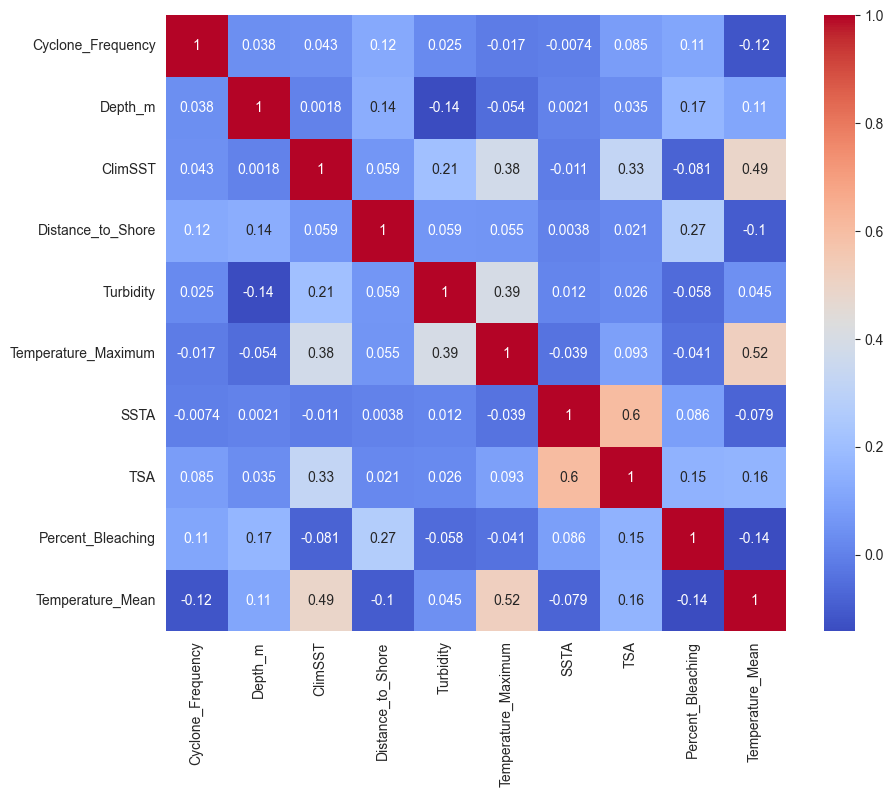

In [84]:
spearman_corr_matrix = df_numeric.corr(method="spearman")
features = spearman_corr_matrix.index

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap="coolwarm")

The VIF analysis reveals severe multicollinearity among temperature-related variables (Temperature_Mean and ClimSST), confirming strong feature redundancy and motivating the use  non-linear models that are less sensitive to collinearity.

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["features"] = num_cols

vif_data["vif"] = [variance_inflation_factor(df_numeric.values, i)
                   for i in range(len(num_cols))]

vif_data

,features,vif
0,Cyclone_Frequency,51.860955
1,Depth_m,4.060596
2,ClimSST,411.180812
3,Distance_to_Shore,1.109021
4,Turbidity,3.253969
5,Temperature_Maximum,55534.515475
6,SSTA,1.607220
7,TSA,2.062368
8,Percent_Bleaching,1.270236
9,Temperature_Mean,54902.395242


A Decision Tree Regressor was trained on the numeric features to estimate feature importance based on impurity reduction. The results indicate that bleaching intensity is influenced by a combination of thermal stress indicators (Temperature_Mean, TSA, SSTA, ClimSST, Temperature_Maximum) and physical/environmental factors (Depth_m, Distance_to_Shore, Cyclone_Frequency, Turbidity). No single variable dominates the prediction, suggesting that coral bleaching is driven by interacting effects rather than a single explanatory factor.


In [91]:
X = df_numeric.drop(target_value_col, axis=1)



model = DecisionTreeRegressor()
model.fit(X, y)

# Feature importance
importance = model.feature_importances_

# Print with feature names
for name, score in zip(X.columns, importance):
    print(f'Feature: {name}, Score: {score:.5f}')


Feature: Cyclone_Frequency, Score: 0.13374
Feature: Depth_m, Score: 0.14005
Feature: ClimSST, Score: 0.08754
Feature: Distance_to_Shore, Score: 0.10903
Feature: Turbidity, Score: 0.07140
Feature: Temperature_Maximum, Score: 0.07209
Feature: SSTA, Score: 0.08806
Feature: TSA, Score: 0.14177
Feature: Temperature_Mean, Score: 0.15631


Overall, the dataset exhibits non-linear relationships, significant feature redundancy, skewed feature distributions, and interaction effects, pushing the use of scaled non-linear models and ensemble methods for robust prediction.


## 5. Data Preprocessing

Before selecting feature set it is better to see the effect of categorical data on DecisionTreeRegressor(), since they carry a lot of environmental data

### 5.1 Handle N/A

During exploratory analysis, it was observed that the **Percent_Cover** feature contains a substantial proportion of missing values (approximately 30%). Rather than applying imputation, which could introduce additional assumptions and bias, the analysis was structured around two variations of the dataset: one including **Percent_Cover** using only samples where it is available, and another excluding the feature entirely to retain the full dataset. Models were trained and evaluated on both dataset versions, which allowed a direct comparison of performance and stability.


### 5.2 Encoding & Transformation and Feature Scaling


In [107]:


df_normalized = df.copy()

right_skewed = {col: data for col, data in skewness_results.items() if data['skewness'] > 0.5}
left_skewed = {col: data for col, data in skewness_results.items() if data['skewness'] < -0.5}

print(left_skewed.keys())
print(right_skewed.keys())
for col_right in right_skewed.keys():
    df_normalized[col_right] = df_normalized[col_right].replace(0, 1e-6)
    df_normalized[col_right], lam = boxcox(df_normalized[col_right])

for col_left in left_skewed.keys():
    pt = PowerTransformer(method='yeo-johnson')
    df_normalized[[col_left]] = pt.fit_transform(df_normalized[[col_left]])


dict_keys(['ClimSST', 'TSA', 'Temperature_Mean'])
dict_keys(['Cyclone_Frequency', 'Depth_m', 'Distance_to_Shore', 'Turbidity', 'Temperature_Maximum', 'Percent_Bleaching'])


C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


,skewness,skew_type
Distance_to_Shore,9.390477,Right (Positive)
Turbidity,3.848336,Right (Positive)
Percent_Bleaching,2.969849,Right (Positive)
ClimSST,-1.640544,Left (Negative)
Temperature_Mean,-1.320474,Left (Negative)
Depth_m,1.272371,Right (Positive)
TSA,-1.013456,Left (Negative)
Temperature_Maximum,0.930379,Right (Positive)
Cyclone_Frequency,0.891588,Right (Positive)


In [ ]:
df_edit = df.drop(columns=[ ], axis=1)

# Split first (no leakage)
X = df_edit.drop(columns=['Percent_Bleaching'])
y = df_edit['Percent_Bleaching']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Since we have categorical variables we need to seperate the numeric and the categorical variables
cat_cols = ['Exposure', 'Bleaching_Level', 'Ocean_Name', 'Country_Name', 'Realm_Name']
num_cols = [col for col in X.columns if col not in cat_cols]



# we do one_hot_encode for categorical features
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat  = ohe.transform(X_test[cat_cols])
X_cat = ohe.transform(X[cat_cols])


# We scale the numeric features
scaler = StandardScaler()

# Even after normalization its still crucial to scale-up data
X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num  = scaler.transform(X_test[num_cols])
X_num = scaler.transform(X[num_cols])


# Combine the categorical and numerical features
X_processed = np.hstack([X_num, X_cat])
X_train_processed = np.hstack([X_train_num, X_train_cat])
X_test_processed  = np.hstack([X_test_num, X_test_cat])


## 5. Feature Importance Analysis

### 5.1 Model-Based Importance

* Tree-based feature importance
* Coefficient-based importance (if applicable)

### 5.2 Insights & Feature Selection Decisions

* Features kept / removed
* Feature transformations

## 7. Support Vector Machines (SVM)

### 7.1 Motivation for SVM

* Suitability for dataset
* Expected benefits

### 7.2 Kernel Experiments

#### 7.2.1 Linear Kernel

```python
# Linear SVM
```

#### 7.2.2 RBF Kernel

```python
# RBF SVM
```

#### 7.2.3 Polynomial Kernel

```python
# Polynomial SVM
```

### 7.3 SVM Results Comparison

* Performance table
* Observations on kernel behavior

---

## 8. Ensemble Tree Models

### 8.1 Model Selection

* Random Forest
* Gradient Boosting / XGBoost / LightGBM (if used)

### 8.2 Initial Ensemble Training

```python
# Initial ensemble model
```

### 8.3 Feature Importance Refinement

* Importance-driven feature pruning
* Retraining with selected features

### 8.4 Hyperparameter Refinement

```python
# Grid or random search
```

### 8.5 Ensemble Results

* Final metrics
* Feature importance visualization

---

## 9. Deep Neural Networks (DNN)

### 9.1 Motivation for DNN

* Non-linearity handling
* High-dimensional interactions

### 9.2 Data Scaling for DNN

```python
# Scaling for neural networks
```

### 9.3 Model Architecture

* Number of layers
* Activation functions
* Regularization methods

```python
# DNN architecture
```

### 9.4 Training & Optimization

* Loss function
* Optimizer
* Early stopping

### 9.5 DNN Performance

* Training vs validation curves
* Final evaluation metrics

---

## 10. Model Comparison

### 10.1 Performance Summary

| Model | Metric 1 | Metric 2 | Notes |
| ----- | -------- | -------- | ----- |

### 10.2 Trade-Off Analysis

* Performance vs complexity
* Training time
* Interpretability

---

## 11. Final Model Selection

* Selected model
* Justification
* Strengths and weaknesses

---

## 12. Conclusions & Future Work

### 12.1 Key Findings

* Data insights
* Model behavior

### 12.2 Limitations

* Data constraints
* Modeling assumptions

### 12.3 Future Improvements

* Feature engineering
* More data
* Model tuning

---

## 13. Appendix

### 13.1 Hyperparameters

### 13.2 Additional Plots

### 13.3 Reproducibility Notes

---

If you want, I can:

* Turn this into a **ready-to-run `.ipynb` template**
* Adapt it for **classification vs regression**
* Add **report-quality plots & tables**
* Align it with **academic / industry ML report standards**

Just tell me 👍

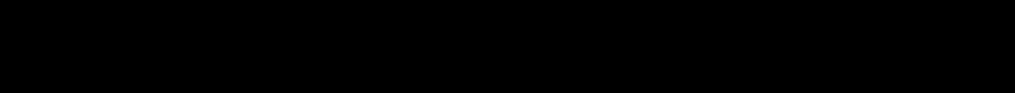
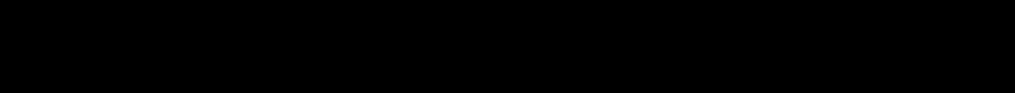
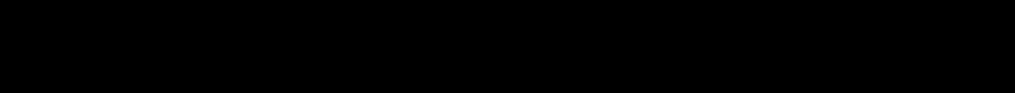
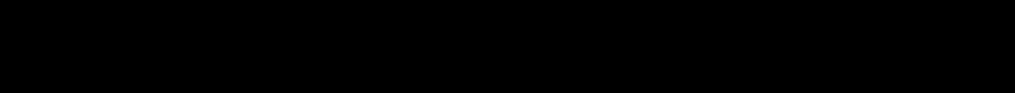
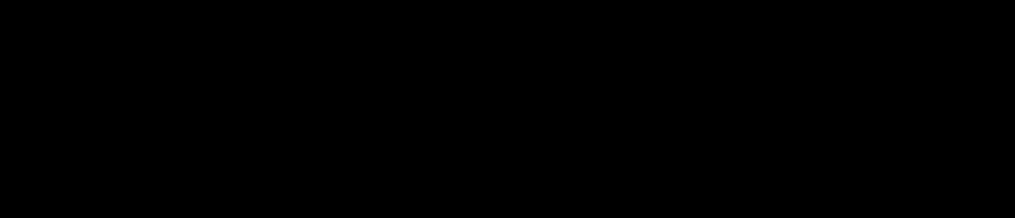